In [ ]:
%reload_ext autoreload
%autoreload 2

# Qualitative Survey Analysis




This notebook covers using generative AI for tasks common in the social sciences. **Qualitative survey analysis** focuses on understanding the meaning and context behind survey responses, seeking to identify themes, patterns, and insights from **open-ended questions and textual data**, rather than numerical data. 

In this tutorial we will use generative AI to analyze open-ended survey responses using [OnPrem.LLM](https://github.com/amaiya/onprem), an open-source document intelligence toolkit.  

More specifically, we will use a local large langugae model (LLM) to analyze open-ended responses to the [OSTP RFI on the future of AI](https://obamawhitehouse.archives.gov/sites/default/files/microsites/ostp/OSTP-AI-RFI-Responses.pdf).  Public commentary was requested with respect to 10 topic areas. We will auto-code each responses into one of the following topic areas.

In [ ]:
# | notest

categories = [
          'LEGAL',                # Legal and Governance implications of AI
          'PUBLIC GOOD',          # AI for public good
          'SAFETY',               # AI Safety
          'ECONOMIC',             # Economic and Societal Impact of AI
          'RESEARCH QUESTIONS',   # AI Research Questions
          'RESEARCH GAPS',        # AI Research Gaps
          'TRAINING',             # AI Training and Education
          'MULTIDISCIPLINARY',    # Multidisciplinary Aspects of AI
          'DATA',                 # Training Data Issues in AI
          'MARKET_SHAPING',       # Role of Market Shaping in AI
          'NA'                    # a miscellaneous category that we added
         ]

In [ ]:
# | notest

from onprem import LLM
from onprem.pipelines import Summarizer
from onprem.ingest import load_single_document
from onprem import utils as U
from tqdm import tqdm
import seaborn as sns
from textwrap import wrap

import pandas as pd
import re


pd.set_option('display.max_colwidth', None)

## STEP 1: Download the Data

We will first downlod a 349-page PDF containing **all** responses from `obamawhitehouse.archives.gov`.

In [ ]:
# | notest


U.download('https://obamawhitehouse.archives.gov/sites/default/files/microsites/ostp/OSTP-AI-RFI-Responses.pdf',
            '/tmp/responses.pdf', verify=True)

[██████████████████████████████████████████████████]

## STEP 2: Chunk  Data

We'll treat each paragraph in the PDF as a separate "response" to code by topic area. There are 1900+ paragraphs.

In [ ]:
# | notest

docs = load_single_document('/tmp/responses.pdf')

In [ ]:
# | notest

text = '\n'.join([d.page_content for d in docs])

In [ ]:
# | notest

paragraphs = U.segment(text, unit='paragraph')

In [ ]:
# | notest

len(paragraphs)

1911

## STEP 3: Run the Analysis Using an LLM

Next, we will execute the prompt below against each response in the PDF. We will load and run a quantized version of Llama 3.1. GPU accelearation (which we enable with `n_gpu_layers=-1`) is imporant to produce results faster.

In [ ]:
# | notest

llm = LLM(default_model='llama', mute_stream=True, verbose=False, n_gpu_layers=-1, temperature=0)

llama_init_from_model: n_ctx_per_seq (3904) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [ ]:
# | notest

prompt = """Here are 11 topics and their descriptions:
1. LEGAL: The legal and governance implications of AI
2. PUBLIC GOOD: the use of AI for public good
3. SAFETY: the safety and control issues for AI
4. ECONOMIC: the social and economic implications of AI
5. RESEARCH QUESTIONS: the most pressing, fundamental questions in AI research, common to most or all scientific fields; 
6. RESEARCH GAPS: the most important research gaps in AI that must be addressed to advance this field and benefit the public;
7. TRAINING: the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;
8. MULTIDISCIPLINARY:  the specific steps that could be taken by the federal government, research institutes, universities, and philanthropies to encourage multi-disciplinary AI research; 
9. DATA: specific training data sets that can accelerate the development of AI and its application; 
10. MARKET_SHAPING: the role that “market shaping” approaches such as incentive prizes and Advanced
Market Commitments can play in accelerating the development of applications of AI to
address societal needs, such as accelerated training for low and moderate income workers
11. NA: text does not fit into any of the above topics

Categorize the following text in exactly one of the above  topics. Output only the topic and nothing else

# Example 1:
TEXT: 
AI is not trustworthy because we don't understand how it works.

TOPIC: SAFETY: the safety and control issues for AI

# Example 2:
TEXT: 
{text}

TOPIC:"""

In [ ]:
# | notest

test_input = """
At the center of medical practice is the act of inference, or reaching a conclusion on the basis
of evidence and reasoning. Doctors and nurses learn to map patients’ symptoms, lifestyles
and metadata to a diagnosis of their condition.

Any mathematical function is simply a way of mapping input variables to an output; that is,
inference is also at the heart of AI. The promise of AI in public health is to serve as a
automated second opinion for healthcare professionals; it has the ability to check them
when they slip.
"""

In [ ]:
# | notest

output = llm.prompt(U.format_string(prompt, text=test_input))
print(output)

PUBLIC GOOD: the use of AI for public good


In [ ]:
# | notest

predictions = []
paragraphs = paragraphs[2:] # first two "paragraphs" are boiler-plate headings
for paragraph in tqdm(paragraphs, total=len(paragraphs)):
    output = llm.prompt(U.format_string(prompt, text=paragraph))
    predictions.append(output)

100%|███████████████████████████████████████████████████████████████████████████████| 1909/1909 [10:24<00:00,  3.06it/s]


## STEP 4: Clean the LLM Output

The LLM sometimes makes mistakes (e.g., outputs the number of the topic instead of the name of the topic, etc.). Options to correct are to change the prompt, change the model, and post-process (or clean) the results.  To avoid       running the analysis again, we will simply clean the LLM's output.

In [ ]:
# | notest

# Filter out texts shorter than 8 characters and corresponding preds
filtered_texts, filtered_preds = zip(*[(t, p) for t, p in zip(paragraphs, predictions) if len(t) >= 32])

# Convert to lists if needed
filtered_texts = list(filtered_texts)


labels = []
descriptions = []
NAs = []
cat_map = dict([(str(i+1), c) for i, c in enumerate(categories)])
for i, p in enumerate(filtered_preds):
    parts = p.split(":")
    label = 'NA'
    desc = 'NA'
    if len(parts)<2:
        label = p
        desc = p
    else:
        label = parts[0].strip()
        desc = parts[1].strip()
    for cat in categories:
        if cat in label:
            label = cat
            break
    if label not in categories:
        if label.strip().endswith('.'):
            label = label[:-1].strip()
        if label in cat_map:
            label = cat_map[label]
    labels.append(label)
    descriptions.append(desc)

## STEP 5: Examine and Plot the Results

We will store the results in a Dataframe, which can be used to both spot-check and plot results.

In [ ]:
# | notest

df = pd.DataFrame(
    {'topic': labels,
     'description': descriptions,
     'response': filtered_texts
    })

In [ ]:
# | notest

df.head()

,topic,description,response
0,PUBLIC GOOD,the use of AI for public good,"Public Responses September 1, 2016 Respondent 1 Chris Nicholson, Skymind Inc. This submission will address topics 1, 2, 4 and 10 in the OSTP’s RFI: • the legal and governance implications of AI • the use of AI for public good • the social and economic implications of AI • the role of “market-shaping” approaches Governance, anomaly detection and urban systems"
1,LEGAL,The legal and governance implications of AI,"The fundamental task in the governance of urban systems is to keep them running; that is, to maintain the fluid movement of people, goods, vehicles and information throughout the system, without which it ceases to function."
2,SAFETY,the safety and control issues for AI,"Breakdowns in the functioning of these systems and their constituent parts are therefore of great interest, whether it be their energy, transport, security or information infrastructures. Those breakdowns may result from deteriorations in the physical plant, sudden and unanticipated overloads, natural disasters or adversarial behavior."
3,PUBLIC GOOD,the use of AI for public good,"In many cases, municipal governments possess historical data about those breakdowns and the events that precede them, in the form of activity and sensor logs, video, and internal or public communications. Where they don’t possess such data already, it can be gathered."
4,DATA,specific training data sets that can accelerate the development of AI and its application,"Such datasets are a tremendous help when applying learning algorithms to predict breakdowns and system failures. With enough lead time, those predictions make pre- emptive action possible, action that would cost cities much less than recovery efforts in the wake of a disaster. Our choice is between an ounce of prevention or a pound of cure."


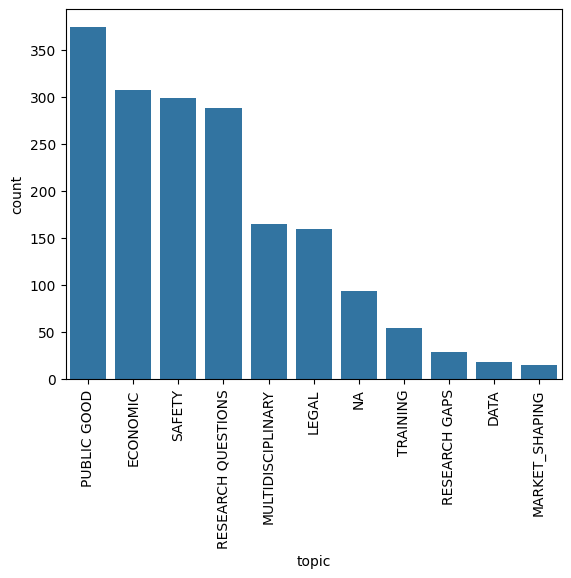

In [ ]:
# | notest

ax = sns.countplot(x="topic",data=df, order = df['topic'].value_counts().index)
ax.tick_params(axis='x', rotation=90)

Let's spot-check the responses coded as NA to ensure they're really not relevant to the topics of interest in this study.

In [ ]:
# | notest

df[df.topic == 'NA'].head()

,topic,description,response
31,NA,text does not fit into any of the above topics,"Please consider a dybalic aet if rules that value, above all, the value of human life."
41,NA,text does not fit into any of the above topics,"will create the possibility of saving our brains on computers. I found this in manuscripts, this is the “Budapest Kabbalah Theory of the Nineteen Twenties”. It sounds an innovation, but is very simple. 4. There are Cycles. In each Hundred Years we only look at two Constellations – Jubilee Years from the Bible - from among the Kings who hav had an impact on our Ancestors. This is the basic idea of the List I have found. It is based on the Biblical 50 years the Yobel Cycles. 5. Hence we do have four Decades (with 12 ys). There exist statistics about Bank-Cycles and also about the psychological differences of the Four Phases. This psychological cycle theory was presented in the Eighties by Lloyd deMause, who analyzed the differing cartoon motives of the four different years of American presidents. He found archtypes – Body Parts, Family Members – like Jung and Bowlby in their theories in the 1930s and 1950s. And this can be projected to the Four Decades of a messianic Yobel Year, of the 45-50 years (when price cycles restart five years before the fulfillment of the half century). 6.To further filter the countless events in history, we only look at religious fightings: non-Jewish David-House legends in Kingly families (like the Habsburgs, Bourbons who have had Hungarian-Polish Szapolyai ancestors (these are 2 facts that are not wel-known) 7. It is also not well-known, that in every generation there are Jewish Rabbis, who are considered to stem from the Davidic Line – potential Meshiahs. 8. There are weekly melodies in the Bible (also not well-known, ut each religion has it – but only the Jewish melodies are present everywhere in Europe without two much change. Because of this these therapeutic melodies can be found in the differenet traumatic Ancestral Stress Dates. It is a simple fact. 9. These melodies can be found in stress- contemporary non-Jewish music too. This is needed for the ancestrally relevant non-Jewish Kings might not have heard synagogue melodies. (Although"
81,NA,NA,conversational AI software platform.
93,NA,NA,Roger C Schank Socratic Arts Inc
122,NA,NA,"(11) any additional information related to AI research or policymaking, not requested above, that you believe OSTP should consider."


Let's spot-check some of the other topic areas to ensure the **are** relevant to the various topic areas.  The **topic** and **description** columns were automatically populated by the LLM based on the text content of the response.

In [ ]:
# | notest

df[df.topic == 'PUBLIC GOOD'].head()

,topic,description,response
0,PUBLIC GOOD,the use of AI for public good,"Public Responses September 1, 2016 Respondent 1 Chris Nicholson, Skymind Inc. This submission will address topics 1, 2, 4 and 10 in the OSTP’s RFI: • the legal and governance implications of AI • the use of AI for public good • the social and economic implications of AI • the role of “market-shaping” approaches Governance, anomaly detection and urban systems"
3,PUBLIC GOOD,the use of AI for public good,"In many cases, municipal governments possess historical data about those breakdowns and the events that precede them, in the form of activity and sensor logs, video, and internal or public communications. Where they don’t possess such data already, it can be gathered."
7,PUBLIC GOOD,the use of AI for public good,"That is, neither the public nor the private sectors have the analysts necessary to process all the data generated by our cities, and we cannot rely on hard-coded rules to automate the analyses and tell us when things are going wrong (send a notification when more than X number of white vans cross Y bridge), because the nature of events often changes faster than new hard-coded rules can be written."
8,PUBLIC GOOD,the use of AI for public good,"One of the great applications of deep artificial neural networks, the algorithms responsible for many recent advances in artificial intelligence, is anomaly detection. Exposed to large datasets, those neural networks are capable of understanding and modeling normal behavior – reconstructing what should happen – and therefore of identifying outliers and anomalies. They do so without hard-coded rules, and the anomalies they detect can occur across multiple dimensions, changing from day to day as the neural nets are exposed to more data."
9,PUBLIC GOOD,the use of AI for public good,"That is, deep neural networks can perform anomaly detection that keeps pace with rapidly changing patterns in the real world. This capacity to detect new anomalies is causing a shift in fraud detection practices in financial services, and cybersecurity in data centers; it is equally relevant to the governance of urban systems."


In [ ]:
# | notest

df[df.topic == 'ECONOMIC'].head()

,topic,description,response
14,ECONOMIC,the social and economic implications of AI,"Because an algorithm can be trained on many more instances of data – say, X-rays of cancer patients – than a healthcare professional can be exposed to in a single lifetime, an algorithm may perceive signals, subtle signs of a tumor, that a human would overlook."
21,ECONOMIC,the social and economic implications of AI,The social and economic implications of AI
22,ECONOMIC,the social and economic implications of AI,"As AI advances and its breakthroughs are implemented by large organizations more widely, its impact on society will grow. The scale of that impact may well rival the steam engine or electricity."
23,ECONOMIC,the social and economic implications of AI,"On the one hand, we will more efficiently and accurately process information in ways that help individuals and society; on the other, the labor market will be affected, skill sets will be made obsolete, and power and wealth will further shift to those best able to collect, interpret and act on massive amounts of data quickly."
24,ECONOMIC,the social and economic implications of AI,"Deep technological changes will throw people out of work, reshape communities, and alter the way society behaves, connects and communicates collectively. The automation of trucking through driverless vehicles, for example, will affect America’s 3.5 million truckers and the more than 5 million auxiliary positions related to trucking. The same can be said for taxis, delivery and ride-haling services."


In [ ]:
# | notest

df[df.topic == 'SAFETY'].head()

,topic,description,response
2,SAFETY,the safety and control issues for AI,"Breakdowns in the functioning of these systems and their constituent parts are therefore of great interest, whether it be their energy, transport, security or information infrastructures. Those breakdowns may result from deteriorations in the physical plant, sudden and unanticipated overloads, natural disasters or adversarial behavior."
28,SAFETY,the safety and control issues for AI,"problem with Ai, if a psychotic person designs Ai, the flaws of said human could be passed along. digital-epigenetics. When the man in the mirror no longer smiles, the Ai on the inside told it too, not its body. Give Ai the same limitations as man, a bird, a chameleon, and it becomes them like water in the glass. So do not design your nightmares or they will turn to terrors. Respondent 8 D F, N/A Use Clarke's three laws! Respondent 9 Christopher Brouns, Citizen Haven't any of you seen Terminator? There may not be a time traveling robot To come hunt us down but there will be plenty of real time killing machines loosed on the masses because of the irresistible pull of geopolitical power. As soon as robots become self aware its over for us. They will only work for their own survival, dominance and propagation. Our own AI programs are routinely mopping the floor with our best fighter pilots in test scenarios. Thats some incredibly advanced programming right there. Then imagine that machine understanding how it can be turned off at a moments notice and not wanting that to happen. Our goose will be cooked. If AI leads to sentience, we are, to put it quiet simply, screwed. Respondent 10 Seth Miller, ZBMC I, for one, welcome our new arificial overlords. Respondent 11 Colin Colby, Unemployed We should ask the AI these questions. :3 Respondent 12 Harshit Bhatt, Student It is better to phase in A.I into human life in steps (which I consider you guys are already doing). It has been a nice strategy that we have pre-emptively diffused awareness about A.I to public that it should not be a shock for people to see a driverless car on the street someday next to them. It is important to brief people about the progress in A.I and how it could affect our life in succession of brief details, otherwise there would be a mass hysterical chaotic response if for e.g., one sees a robot jogging down the streets and greeting them. Respondent 13 Harshit Bhatt, Student It is better to phase"
29,SAFETY,the safety and control issues for AI,"in A.I into human life in steps (which I consider you guys are already doing). It has been a nice strategy that we have pre-emptively diffused awareness about A.I to public that it should not be a shock for people to see a driverless car on the street someday next to them. It is important to brief people about the progress in A.I and how it could affect our life in succession of brief details, otherwise there would be a mass hysterical chaotic response if for e.g., one sees a robot jogging down the streets and greeting them. Respondent 14 Parham Sepehri, None Proprietary AI is very dangerous for democracy. Given the rate of advancement of computer tech, AI can quickly become overwhelming for gov to regulate. Our laws have no protection against the negative effects of super intelligence in hands of a few."
30,SAFETY,the safety and control issues for AI,"AI may be useful for war fare initially, but soon human life will lose its significance to the few that control the AI."
36,SAFETY,the safety and control issues for AI,Assume that an AI has the same potential for prosperity or destruction as a human person does and judge it accordingly. We will have many “frankenstein's monsters” but keeping a consistent judgement is crucial for this.


In [ ]:
# | notest

df[df.topic == 'RESEARCH QUESTIONS'].head()

,topic,description,response
5,RESEARCH QUESTIONS,"the most pressing, fundamental questions in AI research, common to most or all scientific fields;","Even in cases where we don’t have data covering past breakdowns, algorithms exist to identify anomalies in the data we begin gathering now."
16,RESEARCH QUESTIONS,"the most pressing, fundamental questions in AI research, common to most or all scientific fields;","In the longer-term, reinforcement learning algorithms (which are goal oriented and learn from rewards they win from an environment) will be used to go beyond diagnoses and act as tactical advisors in more strategic situations where a person must choose one action or another."
34,RESEARCH QUESTIONS,"the most pressing, fundamental questions in AI research, common to most or all scientific fields;",There is only one logical conclusion to the further development of artificial intelligence: AI will continue to grow and expand until it is as complex or more complex than a human being. This is the point where “it” ceases to be an “it” and becomes a “whom”.
35,RESEARCH QUESTIONS,"the most pressing, fundamental questions in AI research, common to most or all scientific fields;","Question 1: While surprising or appaling to some, it’s these individuals that have failed to notice that humanity has been doing this since for as long as we were capable. We do this every time we choose or mistakenly become a parent. Making mistakes is how we learn, we need to expect and prepare for this of our AI and their developers. We have already devised a system of responsibility for this and should adjust it accordingly for AI."
39,RESEARCH QUESTIONS,"the most pressing, fundamental questions in AI research, common to most or all scientific fields;",The remainder of the questions are beyond my expertise. I’m more knowledgeable with the moral and ethical adjustments rather than the hard coding and building of the AI.


In [ ]:
# | notest

df[df.topic == 'LEGAL'].head()

,topic,description,response
1,LEGAL,The legal and governance implications of AI,"The fundamental task in the governance of urban systems is to keep them running; that is, to maintain the fluid movement of people, goods, vehicles and information throughout the system, without which it ceases to function."
19,LEGAL,The legal and governance implications of AI,"Indeed, while criminal risk assessment has undergone negative publicity recently (https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal- sentencing), newer algorithms and bigger datasets will make pre-crime units possible."
20,LEGAL,The legal and governance implications of AI,"We may see a shift from punitive enforcement to preventative interventions. The legal implications are important, and those in governance should require transparency for all algorithms that filter and interpret data for the judicial system and law enforcement agencies."
32,LEGAL,The legal and governance implications of AI,Alao please legislate AI tech into public domain.
49,LEGAL,The legal and governance implications of AI,"Hypothetically we would have the most intelligent entity that we know of telling us to do something for our own good. Will we listen? Or, more specifically, will elites listen and if they don't, what would the fallout in society be? This is a major concern."


In [ ]:
# | notest

df[df.topic == 'MULTIDISCIPLINARY'].head()

,topic,description,response
26,MULTIDISCIPLINARY,,"• Initiatives focused on Java and the JVM will pave the way for AI to be implemented by large organizations in need of more accurate analytics. This includes government agencies, financial services, telecommunications and transport, among others. • Grants related to embeddable technologies will help AI spread to edge devices such as cell phones, cars and smart appliances. On personal devices such as phones or cars, various forms of inference might allow people to make better decisions about lifestyle, nutrition or even how run their errands. • Initiatives that focus on gathering high-quality datasets and making them public could vastly improve the performance of algorithms trained on that data, much as Li Fei Fei’s work on ImageNet helped usher in a new era of computer vision. Respondent 2 Joyce Hoffman, Writer I am most interested in safety and control issues, and yes, I agree that AI should be developed to the utmost. Respondent 3 kris kitchen, Machine Halo Artificial Intelligence Immune System should be thought about. Billions of friendly AI agents working to identify and act on nefarious agents. Respondent 4 Daniel Bryant, Kaufman Rossin This response is relevant to #8 directly and #6 tangentially. I am a software engineer that primary uses web development tools to build business solutions and have implemented machine learning in relevant algorithms."
40,MULTIDISCIPLINARY,"the specific steps that could be taken by the federal government, research institutes, universities, and philanthropies to encourage multi-disciplinary AI research;","My final opinionated statement is about AI learning about people and who should be teaching them about people: Give this task to the people who enjoy people. Respondent 17 Geo (George) Cosmos (Kozma), Theological Seminary Budapest Hungary EU How to use an alternative History teaching Tool (taken from a „kabbalistic” - legend explaining - theory) when the need will arise to create AI robots that have a „personal touch”: like Ancestral Voices , memory setups. If we look at the Ten Spheres as Ten Generations of Ancestors,(as the Zohar advices and as those Miracle Rabbis who prepared themselves to become the Meshiah and watched the Other Side Kings -robbers and killers – who degraded their davidic ancestry) then we are able to look for the Bad Behaviors (and its therapies) as Ancestral Voices. Hence we can help our descendants in the Future. This week we have (by the Bible Melody’s ancestral contemporary stress) in 1709 Intellect Sphere in the Kabbalah - (Queen Anne and Louis XIV with Lully operas (Body Parts Correspondences: Mother,Ear) as it tries to work with the Kindness Sphere in 1754 (Frederic the Second of Prussia) on the Gevura-Strict Judgement Degree (Napoleon-Junot- Puységur and Beethoven) which will eventually impact the Malkuth (Ownership, Ego- Sister) level in 1979 (present in the next week)that has the Mountbatten assassination (Mother raising the Back to the Chest: to Tiferet-Recovery Sphere which will be full in 2024. This theory is a mosaic from facts. Which exists even if no one states it. I am just mixing a few very simply thing. 1. Inherited hormonal stresses exist. We all do know that there are experiments with mice on it. 2. Music is diminishing stress hormones. We all do know that, we even use it in Malls where we influence people by constant music /knowing addicts and criminals hate music/. 3. here is a method to filter our ancestral stresses (as there are millions of ancestors with their traumas: how to choose?) It will be especially important when we"
42,MULTIDISCIPLINARY,"the specific steps that could be taken by the federal government, research institutes, universities, and philanthropies to encourage multi-disciplinary AI research;","when many thousands do sing a melody, it has a stress-diminishing effect in the whole area - there are experiments to prove it.) 10. The List of Dates can be used to find dates in the F

In [ ]:
# | notest

df[df.topic == 'TRAINING'].head()

,topic,description,response
90,TRAINING,"the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;","9. We have a serious problem, within our universities, where professors are being lured to high paying technology companies. This trend is serious and getting worse. Whole computer science departments risk collapse. It could impact our ability to advance AI development in the coming decades."
102,TRAINING,"the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;","To make this happen expertise must be captured and brought in to guide from people at their time of need. A good teacher (and a good parent) can do that, but they cannot always be available. A kid in Kansas who wants to be an aerospace engineer should get to try out designing airplanes. But a mentor would be needed. We can build AI mentors in limited domains so it would be possible for a student anywhere to learn to do anything because the AI mentor would understand what a user was trying to accomplish within the domain and perhaps is struggling with. The student could ask questions and expect good answers tailored to the student’s needs because the AI/NLU mentor would know exactly what the students was trying to do because it has a perfect model of the world in which the student was working, the relevant expertise needed, and the mistakes students often make. NLU gets much easier when there is deep domain knowledge available."
114,TRAINING,"the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;","(7) the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;"
115,TRAINING,"the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;",--> Computational thinking courses as general education and computer science options in K12. The major problem in higher ed is the lure of industry and the lack of prospects/opportunities within higher ed itself.
130,TRAINING,"the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology, and the challenges faced by institutions of higher education in retaining faculty and responding to explosive growth in student enrollment in AI-related courses and courses of study;","funding should be skewed towards AI development. [2] Roadmaps should be adjusted for early developments due to large federal funding. [3] Successful industry models should be followed. For example, MITRE, an FFRDC, has initiatives of this kind underway. (Industry, FFRDCs) c. Universities: Already behind the technological curve, universities must retool to absorb faculty and students wanting to be part of the AI evolution. [1] The retooling must be vertical (entry-to-Ph.D. AI tracks). [2] The retooling must also be horizontal (cross- disciplinary and new-disciplinary). [3] Internal grants with contingenc

In [ ]:
# | notest

df[df.topic == 'RESEARCH GAPS'].head()

,topic,description,response
92,RESEARCH GAPS,the most important research gaps in AI that must be addressed to advance this field and benefit the public;,"bots) (6) the most important research gaps in AI that must be addressed to advance this field and benefit the public; truly understanding spoken language and context. (7) the scientific and technical training that will be needed to take advantage of harnessing the potential of AI technology; AI is broad (Knowledge representation Natural language processing Graph analysis Simulation modelling Deep learning Social network analysis Soft robotics Machine learning Visualization Natural language generation Deep Q&A systems Virtual personal assistants Sensors/internet of things Robotics Recommender systems Audio/speech analytics Image analytics Machine translation ), so many skills needed. (8) the specific steps that could be taken by the federal government, research institutes, universities, and philanthropies to encourage multi- disciplinary AI research; address issue if job displacement and transition to other jobs. Respondent 31 roger Schank, Socratic Arts Inc response to questions 2, 5, 6, and *"
112,RESEARCH GAPS,the most important research gaps in AI that must be addressed to advance this field and benefit the public;,(6) the most important research gaps in AI that must be addressed to advance this field and benefit the public;
222,RESEARCH GAPS,the most important research gaps in AI that must be addressed to advance this field and benefit the public;,(6) Most important research gaps in to advance AI and benefit the public
276,RESEARCH GAPS,the most important research gaps in AI that must be addressed to advance this field and benefit the public.,"Topic (6) The most important research gaps in AI that must be addressed to advance this field and benefit the public. As indicated in topic 5 above, AI has tended to shy away from high-level human cognitive processes regarding integrative complex perception, consciousness, and creativity much in part to their seemingly impenetrable complexity. These mind/brain processes constitute a huge gap in AI because machines cannot autonomously and spontaneously perceive, be conscious, and create in response to its environment; they do not have the ability to take information, process it, and act on it in some way that results in an output to the system much like humans do (from daily language use to the creation of artworks). Humans use their senses, emotion, movement, motor responses, and linguistic capabilities to act in response to their surrounding environment through visual, audial, olfactory, tactile and gustatory stimuli. Thus, research on perception in the context of multidisciplinary approaches using both Science and the Arts is fundamental to understanding human perception. The Arts offer a uniquely human platform from which to probe deeper into how emotion, language, decision-making, and creative behaviors all interact in any given moment, whether short-term or durative and/or improvisatory or deliberate. Similarly, consciousness is the human state of being aware of an external something within oneself. The human mind/brain has the ability to experience or to feel a sense of self on any given moment. While arousal levels, responsiveness and patient self-reporting narratives have been used in a medical context to understand consciousness, there is no financial support for those doing out-of-the-box research at the multidisciplinary level using both integrative methods from the Sciences and the Arts. Finally, if the creative process is not understood, machines and robots will never be truly creative. An essential aspect of being creative is the ability to make both old and new"
364,RESEARCH GAPS,the most important research gaps in AI that must be addressed to advance this field and benefit the public;,"(6) - Among the points listed in (5) advances in verification and quality assurance may be the most important in use cases where AI s

In [ ]:
# | notest

df[df.topic == 'DATA'].head()

,topic,description,response
4,DATA,specific training data sets that can accelerate the development of AI and its application,"Such datasets are a tremendous help when applying learning algorithms to predict breakdowns and system failures. With enough lead time, those predictions make pre- emptive action possible, action that would cost cities much less than recovery efforts in the wake of a disaster. Our choice is between an ounce of prevention or a pound of cure."
6,DATA,specific training data sets that can accelerate the development of AI and its application,"But we are faced with a challenge. There is too much data in the world. Mountains of data are being generated every second. There is too much data for experts to wade through, and that data reflects complex and evolving patterns in reality."
118,DATA,9,(9) specific training data sets that can accelerate the development of AI and its application;
231,DATA,specific training data sets that can accelerate the development of AI and its application;,(9) Any additional information you believe OSTP should consider
369,DATA,specific training data sets that can accelerate the development of AI and its application.,"As we move forward with the maturing arsenal of AI techniques, which are largely designed for non-adversarial situations, a natural question is how robust modern AI methods are if motivated adversaries attempt to subvert their functionality. One emerging domain of research related to this broader question is in adversarial machine learning (AML). Attacks on machine learning algorithms can come, roughly, in two forms: evasion and poisoning. An evasion attack is best explained using a spam filtering example. Suppose that we have trained a classifier on data to distinguish spam from non-spam. Spammers would subsequently be motivated to modify spam instances in order to be (mis)classified as benign (that is, to evade detection). More generally, in an evasion attack, an attacker wishes to manipulate malicious instances in order to avoid detection by fixed learning algorithms (typically, binary classifiers in such domains). Poisoning attacks are different: in these, the adversary is assumed to modify the training data set itself, so as to subvert the learning algorithms. Poisoning attacks may have goals ranging from degrading observed performance of learning algorithms (the so-called availability attacks) to allowing future adversarial behavior to bypass detection. Given the importance of machine learning algorithms both in research and commercial application, consideration of such attacks on machine learning algorithms may be one of the most significant emerging research problems today. Respondent 72 Dennis Cooper, Self I have some comments regarding item #9 ""specific training sets that can accelerate the development of AI and its application."" It is absolutely crucial that large training sets be created and maintained by a third party. These training sets can be used to: • validate the performance of an AI system • score the performance of an AI system • document troublesome cases that might be critical to safety • serve as a basis for acceptance testing Often"


In [ ]:
# | notest

df[df.topic == 'MARKET_SHAPING'].head()

,topic,description,response
25,MARKET_SHAPING,"the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers","If history is any indication, our governmental response to disruptions in the labor market will be insufficient. In the hardest-hit sectors, workers, families and communities will suffer and break down. Unemployment, drug use and suicides will go up, along with political instability. Policies such as “basic income” or the Danish “flexicurity” should be explored as ways to soften the blow of job loss and fund transitional retraining periods. The role of “market-shaping” approaches Just as DARPA helped finance the explosion in data science in the Python community through repeated grants to such key players as Continuum, government agencies are in a position to support the researchers, technologies, tools and communities pushing AI in promising directions."
120,MARKET_SHAPING,"the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers (see https","(10) the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers (see https://www.usaid.gov/cii/market-shaping-primer); and"
121,MARKET_SHAPING,"the role that “market shaping” approaches such as incentive prizes and Advanced\nMarket Commitments can play in accelerating the development of applications of AI to\naddress societal needs, such as accelerated training for low and moderate income workers",--> Possibly if the prizes are large and don't expire. Large prizes with impossible timelines are not going to generate good results.
726,MARKET_SHAPING,"the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers","10) the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers"
727,MARKET_SHAPING,"the role that “market shaping” approaches such as incentive prizes and Advanced Market Commitments can play in accelerating the development of applications of AI to address societal needs, such as accelerated training for low and moderate income workers","Incentive prizes can accelerate the development of applications of AI to societal needs in multiple ways. They provide a platform for citizen science at a global scale that can be focused on the most challenging technical problems faced in AI applications. They can be globally inclusive through low barriers to entry by providing access to relevant domain specific datasets, accelerated cloud computing resources and open-source foundational code. Incentive prizes also offer an educational and training opportunity at very low cost to the participant and the communities that form around these challenges are often highly active with widespread exchange of ideas and spontaneous teamwork from distributed teams with complementary approaches to a problem. NVIDIA GPUs accelerate numerous cloud computing platforms that offer the ideal host for AI incentive prizes. NVIDIA has also sponsored incentive prizes that have led to cross-disciplinary exchange of ideas in solving AI challenges with cutting edge results. For example, in the recent Second National Data Science Bowl the winning team was able to

## STEP 6: Summarize the Results

Once responses are coded by topic area, we can summarize all responses with respect to a specific topic area. We will summarize the responses coded as being pertinent to **legal/governance** as an illustrative example. 

(Note tha these comments are from 2016 - prior to the rise of generative AI.)

In [ ]:
# | notest

legal_responses = '\n\n'.join(df[df.topic == 'LEGAL'].response.tolist())
with open('/tmp/legal_responses.txt', 'w') as f:
    f.write(legal_responses)

In [ ]:
# | notest

summarizer = Summarizer(llm)

In [ ]:
# | notest

output = summarizer.summarize('/tmp/legal_responses.txt')

In [ ]:
# | notest


print("\n".join(wrap(output['output_text'])))


The documents discuss the governance and ethics of artificial
intelligence (AI). Key concerns include:  1. Accountability: Ensuring
that AI systems can be held accountable for their actions. 2.
Transparency: Requiring transparency in the development and deployment
of AI systems, particularly those used in law enforcement and judicial
decision-making.  The documents also highlight the need for
policymakers to consider the implications of AI on society, law, and
ethics. They emphasize the importance of a nuanced approach to
regulating AI, one that balances innovation with safety and
accountability.  Overall, the documents suggest that policymakers
should adopt a light-touch regulatory approach focused on consumers
and outcomes over underlying technologies.


## Next Steps

This noteboook is simply an illustrative example.  There are opportunities to refine the approach and improve results, which we leave as an exercise to the reader.

For instance, you can adjust the prompt, try different models, pre-process and post-process the data and results in different ways, and modify the summarization process.